In [1]:
from openmm import *
from openmm.app import *
from openmm.unit import *
import pandas as pd
import numpy as np
# from scipy.stats import linregress

In [2]:
class MSDReporter:
    def __init__(self, interval, simulation, dt):
        self.interval = interval
        state0 = simulation.context.getState(getPositions=True, enforcePeriodicBox=False)
        self.x0 = state0.getPositions(asNumpy=True).value_in_unit(centimeter)
        self.dt = dt.value_in_unit(second)
        self.label = dict(Time=[], MSD=[])

    def describeNextReport(self, simulation):
        steps = self.interval - simulation.currentStep % self.interval
        return (steps, True, False, False, False, False)

    def report(self, simulation, state):
        x = state.getPositions(asNumpy=True).value_in_unit(centimeter)
        msd = np.mean(np.linalg.norm((x - self.x0), axis=1) ** 2)
        time = state.getStepCount() * self.dt
        self.label['Time'].append(time)
        self.label['MSD'].append(msd)

In [3]:
# Input Files

pdb = PDBFile('mW.pdb')
forcefield = ForceField('mW.xml')
# forcefield = ForceField('amber14/tip3pfb.xml')

# System Configuration

nonbondedMethod = PME
nonbondedCutoff = 0.43*nanometers
constraints = None
rigidWater = False

# Integration Options

dt = 0.005*picoseconds
temperature = 298*kelvin
friction = 1.0/picosecond
pressure = 1.0*bar
barostatInterval = 25

# Simulation Options

steps = 600000
equilibrationSteps = 1000
platform = Platform.getPlatformByName('CUDA')
platformProperties = {'Precision': 'single'}
platformProperties["DeviceIndex"] = "0"
dcdReporter = DCDReporter('trajectory.dcd', 1000, enforcePeriodicBox=False)
dataReporter = StateDataReporter('log.txt', 1000, totalSteps=steps, remainingTime=True,
    step=True, speed=True, progress=True, potentialEnergy=True, temperature=True, density=True, separator='\t')


In [4]:
# Prepare the Simulation

print('Building system...')
topology = pdb.topology
positions = pdb.positions
system = forcefield.createSystem(topology, nonbondedMethod=nonbondedMethod, nonbondedCutoff=nonbondedCutoff,
                                 constraints=constraints, rigidWater=rigidWater, removeCMMotion=False)
integrator = LangevinMiddleIntegrator(temperature, friction, dt)
simulation = Simulation(topology, system, integrator, platform, platformProperties)
simulation.context.setPositions(positions)

Building system...


In [5]:
# Minimize and Equilibrate

print('Performing energy minimization...')
simulation.minimizeEnergy()
print('Equilibrating...')
simulation.context.setVelocitiesToTemperature(temperature)
simulation.step(equilibrationSteps)
system.addForce(MonteCarloBarostat(pressure, temperature, barostatInterval))
simulation.context.reinitialize(preserveState=True)
simulation.step(equilibrationSteps)

Performing energy minimization...
Equilibrating...


In [6]:
# Simulate

print('Simulating...')
msdReporter = MSDReporter(100, simulation, dt)
simulation.reporters.append(dcdReporter)
simulation.reporters.append(dataReporter)
simulation.reporters.append(msdReporter)
simulation.currentStep = 0

simulation.step(steps)

print('done')
df = pd.DataFrame(msdReporter.label)
# linear_model = linregress(df['Time'], df['MSD'])
# slope = linear_model.slope
# D = slope / 6
# print(D)
df

Simulating...


KeyboardInterrupt: 

In [10]:
import matplotlib.pyplot as plt

In [12]:
df=pd.DataFrame(msdReporter.label)

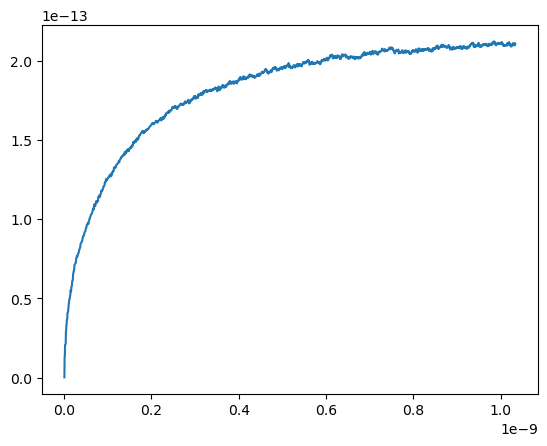

In [14]:
plt.plot(df['Time'],df['MSD'])